In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple

In [ ]:
class FaceDetector:
    def __init__(self):
        self.cascade_classifier: cv2.CascadeClassifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        self.landmark_model = cv2.face.createFacemarkLBF()
        self.landmark_model.loadModel("lbfmodel.yaml")

    def detect(self, img_path: str) -> Tuple[np.ndarray, List[np.ndarray], List[Tuple[int, int]], List[np.ndarray]]:
        """
        detects and highlights the location of faces and the locations of facial landmarks in a given image

        IN:
            img_path: str: relative or absolute path to the input image
        
        OUT:
            img_bgr: np.ndarray: matrixlike, BGR converted image with faces highlighted
            face_rectangles: List[np.ndarray]: list of rectangles in the format (x, y, height, width)
            face_centers: List[Tuple[int, int]]: list of tuples containing center coordinates in the format (x, y)
            landmarks_all_faces: List[np.ndarray]: list of n = num_faces numpy arrays each containing 68 landmark coordinates in the format [x, y]
        """
        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_bgr = cv2.cvtColor(img_read, cv2.COLOR_GRAY2BGR)

        face_rectangles = self.cascade_classifier.detectMultiScale(img_bgr, scaleFactor=1.1, minNeighbors=5)
        face_centers: List[Tuple[int, int]] = []

        for (x, y, width, height) in face_rectangles:
            cv2.rectangle(img_bgr, (x, y), (x + width, y + height), (0, 255, 0), 2)

            center_x, center_y = x + (width // 2), y + (height // 2)
            cv2.circle(img_bgr, (center_x, center_y), 3, (0, 0, 255), -1)

            face_centers.append((center_x, center_y))

        _, landmarks_all_faces = self.landmark_model.fit(img_read, face_rectangles)

        landmarks_all_faces = [landmarks[0] for landmarks in landmarks_all_faces]

        for landmarks_face in landmarks_all_faces:
            for (x, y) in landmarks_face:
                cv2.circle(img_bgr, (int(x), int(y)), 1, (255, 0, 0), -1)

        return img_bgr, list(face_rectangles), face_centers, landmarks_all_faces
    
    def mask_points(self, img_path: str, landmarks: List[np.ndarray]) -> Tuple[np.ndarray, List[List[Tuple[int, int]]]]:
        """
        filters out and highlights critical facial landmarks given an image and a collection of all its detected landmarks

        IN: 
            img_path: str: relative or absolute path to the input image
        
        OUT:
            img_bgr: np.ndarray: matrixlike, BGR converted image with intended mask points highlighted
            selected_pts: List[List[Tuple[int, int]]]: list of n = num_faces lists containing 7 coordinates in the format (x, y) 
        """
        img_read = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_bgr = cv2.cvtColor(img_read, cv2.COLOR_GRAY2BGR)

        idxs = [18, 25, 48, 54, 36, 45, 51]

        selected_pts: List[List[Tuple[int, int]]] = []
        for lm in landmarks:
            face_pts = []
            for i in idxs:
                x, y = lm[i]
                face_pts.append((int(x), int(y)))
                cv2.circle(img_bgr, (int(x), int(y)), 3, (0,255,255), -1)
            selected_pts.append(face_pts)

        return img_bgr, selected_pts

    def display(self, bgr_img: np.ndarray, mask_points: List[List[Tuple[int, int]]] = None, img_path: str = None) -> None:
        """
        displays a BGR-format image with option to also display masked facial regions.

        IN:
            bgr_img: np.ndarray: image in BGR format to be displayed
            mask_points: Optional List[List[Tuple[int, int]]]: list of face masks to highlight (convex hulls)
            img_path: Optional str: path to original image (needed to generate clean masked version)
        """

        img_rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

        if mask_points:
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            img_original_bgr = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

            mask = np.zeros(img_gray.shape, dtype=np.uint8)
            for face_polygon in mask_points:
                polygon = np.array(face_polygon, dtype=np.int32)
                hull = cv2.convexHull(polygon)
                cv2.fillPoly(mask, [hull], color=255)

            masked_bgr = cv2.bitwise_and(img_original_bgr, img_original_bgr, mask=mask)
            masked_rgb = cv2.cvtColor(masked_bgr, cv2.COLOR_BGR2RGB)

            plt.imshow(masked_rgb)
            plt.axis('off')
            plt.show()




In [42]:
face_detector = FaceDetector()

In [43]:
img, rects, cents, landmarks = face_detector.detect("test_images/faces.jpg")

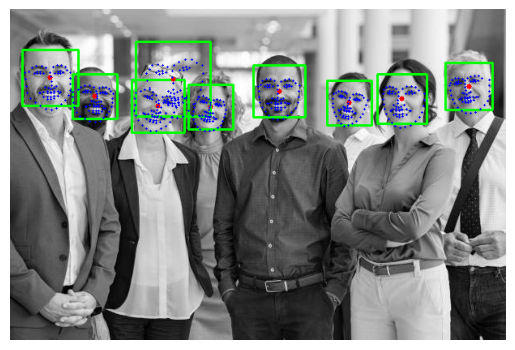

In [44]:
face_detector.display(img)

In [45]:
image_mask_pts, pts = face_detector.mask_points("test_images/faces.jpg", landmarks)

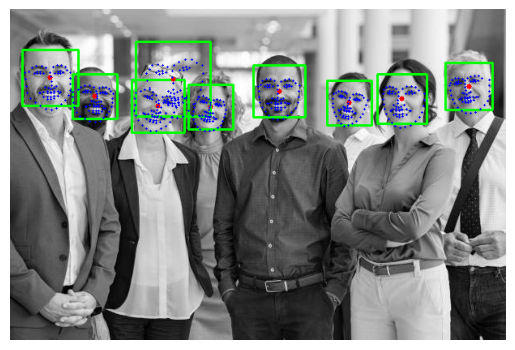

In [46]:
face_detector.display(img)

In [47]:
np.array(pts)

array([[[ 27,  72],
        [ 68,  71],
        [ 36, 103],
        [ 62, 102],
        [ 30,  79],
        [ 65,  78],
        [ 50, 102]],

       [[405, 101],
        [434, 106],
        [405, 124],
        [426, 128],
        [406, 107],
        [431, 112],
        [415, 125]],

       [[ 87,  96],
        [122,  98],
        [ 93, 120],
        [117, 122],
        [ 90, 102],
        [119, 104],
        [106, 119]],

       [[233, 108],
        [263, 114],
        [233, 131],
        [254, 135],
        [235, 114],
        [260, 119],
        [244, 132]],

       [[464,  96],
        [500,  96],
        [469, 125],
        [494, 125],
        [466, 103],
        [499, 103],
        [480, 124]],

       [[545,  87],
        [578,  82],
        [554, 111],
        [577, 108],
        [548,  92],
        [577,  88],
        [564, 109]],

       [[166,  99],
        [202, 108],
        [164, 128],
        [190, 135],
        [166, 107],
        [197, 116],
        [178, 132]],

      